# Predictive Modelling using Machine Learning Algorithms

In [151]:
import pandas as pd
import numpy as np
import duckdb as db
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import optuna
import warnings
import seaborn as sns
sns.set_theme(context='notebook', style='whitegrid')

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# pd.set_option('plotting.backend', 'plotly')
# pio.renderers.default = "notebook_connected"
optuna.logging.set_verbosity(optuna.logging.ERROR)
from sklearn.linear_model import LinearRegression
# elastic net
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
# lightgbm
import lightgbm as lgb
from lightgbm import LGBMRegressor

# xgboost
import xgboost as xgb
from xgboost import XGBRegressor

import mlflow
import pickle

In [39]:
import sys
import os
from pathlib import Path

# Get my_package directory path from Notebook
parent_dir = str(Path().resolve().parents[1])

# Add to sys.path
sys.path.insert(0, parent_dir)

# Assuming 'helpers.py' is in the 'SalesForecasting' directory
from SalesForecasting.utils.helpers import smape

In [37]:
smape(1, 1)

0.0

In [72]:
orig = pd.read_parquet("../../data/processed/train_enhanced.parquet")

In [73]:
orig

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Orders,Sales,...,Day,Day_of_Week,Month_Name,Month,Year,Quarter,Week,Week_of_Month,Is_Weekend,cluster
0,T1000001,1,S1,L3,R1,2018-01-01,1,1,9,7011.84,...,1,0,January,1,2018,1,1,1,0,3
1,T1000002,253,S4,L2,R1,2018-01-01,1,1,60,51789.12,...,1,0,January,1,2018,1,1,1,0,2
2,T1000003,252,S3,L2,R1,2018-01-01,1,1,42,36868.20,...,1,0,January,1,2018,1,1,1,0,1
3,T1000004,251,S2,L3,R1,2018-01-01,1,1,23,19715.16,...,1,0,January,1,2018,1,1,1,0,4
4,T1000005,250,S2,L3,R4,2018-01-01,1,1,62,45614.52,...,1,0,January,1,2018,1,1,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188335,T1188336,149,S2,L3,R2,2019-05-31,1,1,51,37272.00,...,31,4,May,5,2019,2,22,5,0,4
188336,T1188337,153,S4,L2,R1,2019-05-31,1,0,90,54572.64,...,31,4,May,5,2019,2,22,5,0,2
188337,T1188338,154,S1,L3,R2,2019-05-31,1,0,56,31624.56,...,31,4,May,5,2019,2,22,5,0,3
188338,T1188339,155,S3,L1,R2,2019-05-31,1,1,70,49162.41,...,31,4,May,5,2019,2,22,5,0,1


In [74]:
print("Min date:", orig["Date"].min(), ", Max date:", orig["Date"].max())

total_days = (orig["Date"].max() - orig["Date"].min()).days
train_max = orig["Date"].min() + pd.DateOffset(days=total_days * 0.8)
print("Total days:", total_days, ", Training days: ",total_days * 0.8 )
print("Train max date:", train_max)


Min date: 2018-01-01 00:00:00 , Max date: 2019-05-31 00:00:00
Total days: 515 , Training days:  412.0
Train max date: 2019-02-17 00:00:00


In [75]:
orig.columns

Index(['ID', 'Store_id', 'Store_Type', 'Location_Type', 'Region_Code', 'Date',
       'Holiday', 'Discount', 'Orders', 'Sales', 'Day_of_Week_Name', 'Day',
       'Day_of_Week', 'Month_Name', 'Month', 'Year', 'Quarter', 'Week',
       'Week_of_Month', 'Is_Weekend', 'cluster'],
      dtype='object')

In [76]:
columns = ['Store_id', 'Store_Type', 'Location_Type', 'Region_Code',
       'Holiday', 'Discount',  'Sales', 'Day', 'Date',
       'Day_of_Week', 'Month', 'Quarter', 'Week',
       'Week_of_Month', 'Is_Weekend', "cluster"]

In [77]:
df=orig[columns]

In [125]:
train = df[df["Date"] <= train_max]
test = df[df["Date"] > train_max]

In [126]:
train

,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,Sales,Day,Date,Day_of_Week,Month,Quarter,Week,Week_of_Month,Is_Weekend,cluster
0,1,S1,L3,R1,1,1,7011.84,1,2018-01-01,0,1,1,1,1,0,3
1,253,S4,L2,R1,1,1,51789.12,1,2018-01-01,0,1,1,1,1,0,2
2,252,S3,L2,R1,1,1,36868.20,1,2018-01-01,0,1,1,1,1,0,1
3,251,S2,L3,R1,1,1,19715.16,1,2018-01-01,0,1,1,1,1,0,4
4,250,S2,L3,R4,1,1,45614.52,1,2018-01-01,0,1,1,1,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150740,33,S4,L2,R4,0,1,73200.00,17,2019-02-17,6,2,1,7,3,1,2
150741,254,S4,L1,R1,0,1,55842.00,17,2019-02-17,6,2,1,7,3,1,2
150742,109,S1,L1,R1,0,1,52578.00,17,2019-02-17,6,2,1,7,3,1,3
150743,303,S4,L2,R1,0,1,69456.00,17,2019-02-17,6,2,1,7,3,1,2


# Feature Engineering

In [122]:
def generate_features(data, table_name='temp_table'):
    # Register the DataFrame as a temporary table
    db.sql(f"CREATE OR REPLACE TEMPORARY TABLE {table_name} AS SELECT * FROM data")

    query = f"""
    SELECT *,
        lag(Sales, 1) over (partition by Store_id order by Date) as Sales_Lag_1,
        lag(Sales, 7) over (partition by Store_id order by Date) as Sales_Lag_7,
        lag(Sales, 12) over (partition by Store_id order by Date) as Sales_Lag_12,
        lag(Sales, 30) over (partition by Store_id order by Date) as Sales_Lag_30,
        avg(Sales) over (partition by Store_id order by Date rows between 7 preceding and 1 preceding) as Sales_Mean_7,
        avg(Sales) over (partition by Store_id order by Date rows between 12 preceding and 1 preceding) as Sales_Mean_12,
        avg(Sales) over (partition by Store_id order by Date rows between 30 preceding and 1 preceding) as Sales_Mean_30,
        stddev_pop(Sales) over (partition by Store_id order by Date rows between 7 preceding and 1 preceding) as Sales_Std_7,
        stddev_pop(Sales) over (partition by Store_id order by Date rows between 12 preceding and 1 preceding) as Sales_Std_12,
        stddev_pop(Sales) over (partition by Store_id order by Date rows between 30 preceding and 1 preceding) as Sales_Std_30,
        avg(Sales) over (partition by Store_id order by Date rows between unbounded preceding and 1 preceding) as Sales_Expanding_Mean,
        stddev_pop(Sales) over (partition by Store_id order by Date rows between unbounded preceding and 1 preceding) as Sales_Expanding_Std,
        sum(Sales) over (partition by Store_id order by Date rows between unbounded preceding and 1 preceding) as Sales_Expanding_Sum,
        --min(Sales) over (partition by Store_id order by Date rows between unbounded preceding and 1 preceding) as Sales_Expanding_Min,
    from {table_name}
    """
    
    result = db.sql(query).df()

    ohe = OneHotEncoder(categories='auto')
    feature_array = ohe.fit_transform(result[['Store_Type', 'Location_Type', 'Region_Code','cluster']]).toarray()
    result = pd.concat([result, pd.DataFrame(feature_array, columns=ohe.get_feature_names_out())], axis=1).drop(['Store_Type', 'Location_Type', 'Region_Code', 'cluster'], axis=1)
    result = result.drop(columns=["Date","Store_id"], axis=1)

    # encode cyclical features
    result['Day_sin'] = np.sin(2 * np.pi * result['Day']/31)
    result['Day_cos'] = np.cos(2 * np.pi * result['Day']/31)

    result['Day_of_Week_sin'] = np.sin(2 * np.pi * result['Day_of_Week']/7)
    result['Day_of_Week_cos'] = np.cos(2 * np.pi * result['Day_of_Week']/7)

    result['Month_sin'] = np.sin(2 * np.pi * result['Month']/12)
    result['Month_cos'] = np.cos(2 * np.pi * result['Month']/12)

    result['Quarter_sin'] = np.sin(2 * np.pi * result['Quarter']/4)
    result['Quarter_cos'] = np.cos(2 * np.pi * result['Quarter']/4)

    result['Week_sin'] = np.sin(2 * np.pi * result['Week']/52)
    result['Week_cos'] = np.cos(2 * np.pi * result['Week']/52)

    result['Week_of_Month_sin'] = np.sin(2 * np.pi * result['Week_of_Month']/5)
    result['Week_of_Month_cos'] = np.cos(2 * np.pi * result['Week_of_Month']/5)

    # drop original cyclical features
    result = result.drop(columns=['Day', 'Day_of_Week', 'Month', 'Quarter', 'Week', 'Week_of_Month'], axis=1)

    result = result.dropna()

    return result


In [127]:
train = generate_features(train)
test = generate_features(test)

In [135]:
# save the data
# with open("./pickles/train_features.pkl", "wb") as f:
#     pickle.dump(train, f)

# with open("./pickles/test_features.pkl", "wb") as f:
#     pickle.dump(test, f)

In [46]:
with open("./pickles/train_features.pkl", "rb") as f:
    train = pickle.load(f)

with open("./pickles/test_features.pkl", "rb") as f:
    test = pickle.load(f)

In [47]:
test

,Holiday,Discount,Sales,Is_Weekend,Sales_Lag_1,Sales_Lag_7,Sales_Lag_12,Sales_Lag_30,Sales_Mean_7,Sales_Mean_12,...,Day_of_Week_sin,Day_of_Week_cos,Month_sin,Month_cos,Quarter_sin,Quarter_cos,Week_sin,Week_cos,Week_of_Month_sin,Week_of_Month_cos
30,1,0,52549.56,0,53622.00,52353.0,46959.0,44214.00,51108.000000,44805.50,...,0.974928,-0.222521,1.0,6.123234e-17,1.000000e+00,6.123234e-17,0.992709,0.120537,-5.877853e-01,-0.809017
31,1,0,6322.44,0,52549.56,52380.0,40545.0,42445.44,51136.080000,45271.38,...,0.433884,-0.900969,1.0,6.123234e-17,1.000000e+00,6.123234e-17,0.992709,0.120537,-5.877853e-01,-0.809017
32,0,0,33516.00,0,6322.44,42585.0,32877.0,43881.00,44556.428571,42419.50,...,-0.433884,-0.900969,1.0,6.123234e-17,1.000000e+00,6.123234e-17,0.992709,0.120537,-9.510565e-01,0.309017
33,0,0,39462.00,1,33516.00,54906.0,28794.0,44658.00,43260.857143,42472.75,...,-0.974928,-0.222521,1.0,6.123234e-17,1.000000e+00,6.123234e-17,0.992709,0.120537,-9.510565e-01,0.309017
34,0,0,40017.00,1,39462.00,49608.0,30735.0,50964.00,41054.571429,43361.75,...,-0.781831,0.623490,1.0,6.123234e-17,1.000000e+00,6.123234e-17,0.992709,0.120537,-9.510565e-01,0.309017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37590,0,1,44748.00,0,52710.00,25305.0,48810.0,44613.00,36595.285714,43154.75,...,0.000000,1.000000,0.5,-8.660254e-01,1.224647e-16,-1.000000e+00,0.464723,-0.885456,-9.510565e-01,0.309017
37591,0,1,49626.00,0,44748.00,28461.0,45921.0,23898.00,39372.857143,42816.25,...,0.781831,0.623490,0.5,-8.660254e-01,1.224647e-16,-1.000000e+00,0.464723,-0.885456,-9.510565e-01,0.309017
37592,0,0,33399.00,0,49626.00,28428.0,57228.0,58209.00,42396.428571,43125.00,...,0.974928,-0.222521,0.5,-8.660254e-01,1.224647e-16,-1.000000e+00,0.464723,-0.885456,-2.449294e-16,1.000000
37593,0,0,35409.00,0,33399.00,32214.0,57228.0,46266.00,43106.571429,41139.25,...,0.433884,-0.900969,0.5,-8.660254e-01,1.224647e-16,-1.000000e+00,0.464723,-0.885456,-2.449294e-16,1.000000


In [48]:
train.columns

Index(['Holiday', 'Discount', 'Sales', 'Is_Weekend', 'Sales_Lag_1',
       'Sales_Lag_7', 'Sales_Lag_12', 'Sales_Lag_30', 'Sales_Mean_7',
       'Sales_Mean_12', 'Sales_Mean_30', 'Sales_Std_7', 'Sales_Std_12',
       'Sales_Std_30', 'Sales_Expanding_Mean', 'Sales_Expanding_Std',
       'Sales_Expanding_Sum', 'Store_Type_S1', 'Store_Type_S2',
       'Store_Type_S3', 'Store_Type_S4', 'Location_Type_L1',
       'Location_Type_L2', 'Location_Type_L3', 'Location_Type_L4',
       'Location_Type_L5', 'Region_Code_R1', 'Region_Code_R2',
       'Region_Code_R3', 'Region_Code_R4', 'cluster_1', 'cluster_2',
       'cluster_3', 'cluster_4', 'Day_sin', 'Day_cos', 'Day_of_Week_sin',
       'Day_of_Week_cos', 'Month_sin', 'Month_cos', 'Quarter_sin',
       'Quarter_cos', 'Week_sin', 'Week_cos', 'Week_of_Month_sin',
       'Week_of_Month_cos'],
      dtype='object')

In [49]:
scaler = StandardScaler()

X_train = train.drop(columns=["Sales"])
X_test = test.drop(columns=["Sales"])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=train.drop(["Sales"], axis=1).columns)
X_test = pd.DataFrame(X_test, columns=test.drop(["Sales"], axis=1).columns)

y_train = train["Sales"]
y_test = test["Sales"]

In [ ]:
# X_train = pd.DataFrame(X_train, columns=train.drop(columns=["Sales"]).columns)
# X_test = pd.DataFrame(X_test, columns=test.drop(columns=["Sales"]).columns)

In [50]:
X_train

,Holiday,Discount,Is_Weekend,Sales_Lag_1,Sales_Lag_7,Sales_Lag_12,Sales_Lag_30,Sales_Mean_7,Sales_Mean_12,Sales_Mean_30,...,Day_of_Week_sin,Day_of_Week_cos,Month_sin,Month_cos,Quarter_sin,Quarter_cos,Week_sin,Week_cos,Week_of_Month_sin,Week_of_Month_cos
0,2.610810,-0.909804,-0.634768,-0.197428,-0.482664,-0.214670,-0.358793,0.220773,0.021384,0.319617,...,1.380249,-0.309017,0.653407,1.204220,1.328246,-0.003777,0.758989,1.111106,-0.031064,1.824747
1,-0.383023,-0.909804,-0.634768,-0.326501,0.062747,-0.114834,0.923482,0.247826,0.008897,0.320220,...,0.615869,-1.269480,1.167313,0.681871,1.328246,-0.003777,0.758989,1.111106,1.225008,0.734470
2,-0.383023,-0.909804,-0.634768,-0.586689,-0.778780,-0.146788,0.513668,0.131415,-0.042549,0.251784,...,-0.610101,-1.269480,1.167313,0.681871,1.328246,-0.003777,0.758989,1.111106,1.225008,0.734470
3,-0.383023,-0.909804,1.575379,-0.533593,0.045589,-0.190805,0.455995,0.174562,-0.084789,0.204075,...,-1.374481,-0.309017,1.167313,0.681871,1.328246,-0.003777,0.758989,1.111106,1.225008,0.734470
4,-0.383023,-0.909804,1.575379,-0.233600,1.550172,-0.370631,0.980167,0.123848,-0.089816,0.172301,...,-1.101677,0.888661,1.167313,0.681871,1.328246,-0.003777,0.758989,1.111106,1.225008,0.734470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139790,-0.383023,-0.909804,-0.634768,-0.674796,1.075535,-1.142990,-0.171930,-0.595030,-0.562455,-0.676557,...,1.380249,-0.309017,1.167313,0.681871,1.328246,-0.003777,1.015055,0.885250,0.745231,-1.029633
139791,-0.383023,1.099137,-0.634768,-1.261675,-1.171769,0.122917,-0.438640,-1.011870,-0.575464,-0.725944,...,0.615869,-1.269480,1.167313,0.681871,1.328246,-0.003777,1.015055,0.885250,0.745231,-1.029633
139792,-0.383023,1.099137,-0.634768,-0.484147,-0.756030,-0.049602,-1.211930,-0.889838,-0.641588,-0.728778,...,-0.610101,-1.269480,1.167313,0.681871,1.328246,-0.003777,1.015055,0.885250,-0.807360,-1.029633
139793,-0.383023,1.099137,1.575379,-0.741332,-0.583795,-0.557885,-0.937403,-0.887601,-0.716827,-0.708406,...,-1.374481,-0.309017,1.167313,0.681871,1.328246,-0.003777,1.015055,0.885250,-0.807360,-1.029633


In [5]:
%env MLFLOW_TRACKING_URI=sqlite:///mlruns.db

env: MLFLOW_TRACKING_URI=sqlite:///mlruns.db


# Linear Regression

In [58]:
mlflow.set_experiment("Linear Regression")
with mlflow.start_run():
    mlflow.set_tag("mlflow.runName", "Default Run")
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mlflow.log_metric("mae", mae)

# Elastic Net Regression

In [149]:
mlflow.set_experiment("ElasitcNet")
def objective_elastic(trial):
    with mlflow.start_run():
        params = {
            "alpha": trial.suggest_float('alpha', 0.0, 1.0),
            "l1_ratio": trial.suggest_float('l1_ratio', 0.0, 1.0)
        }
        en = ElasticNet(**params, random_state=42)
        en.fit(X_train, y_train)
        y_pred = en.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mlflow.log_metric("mae", mae)
        mlflow.log_params(params)
        return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective_elastic, n_trials=50)

# Random Forest

In [119]:
mlflow.set_experiment("Random Forest Default")
with mlflow.start_run():
    mlflow.set_tag("mlflow.runName", "f_run")
    params = {
        "n_estimators": 80,
        # "max_depth": 8,
    }
    rf = RandomForestRegressor(n_jobs=-1, **params)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mlflow.log_metric("mae", mae)
    mlflow.log_params(params)

In [120]:
mean_absolute_error(y_test, y_pred)

6556.791274835803

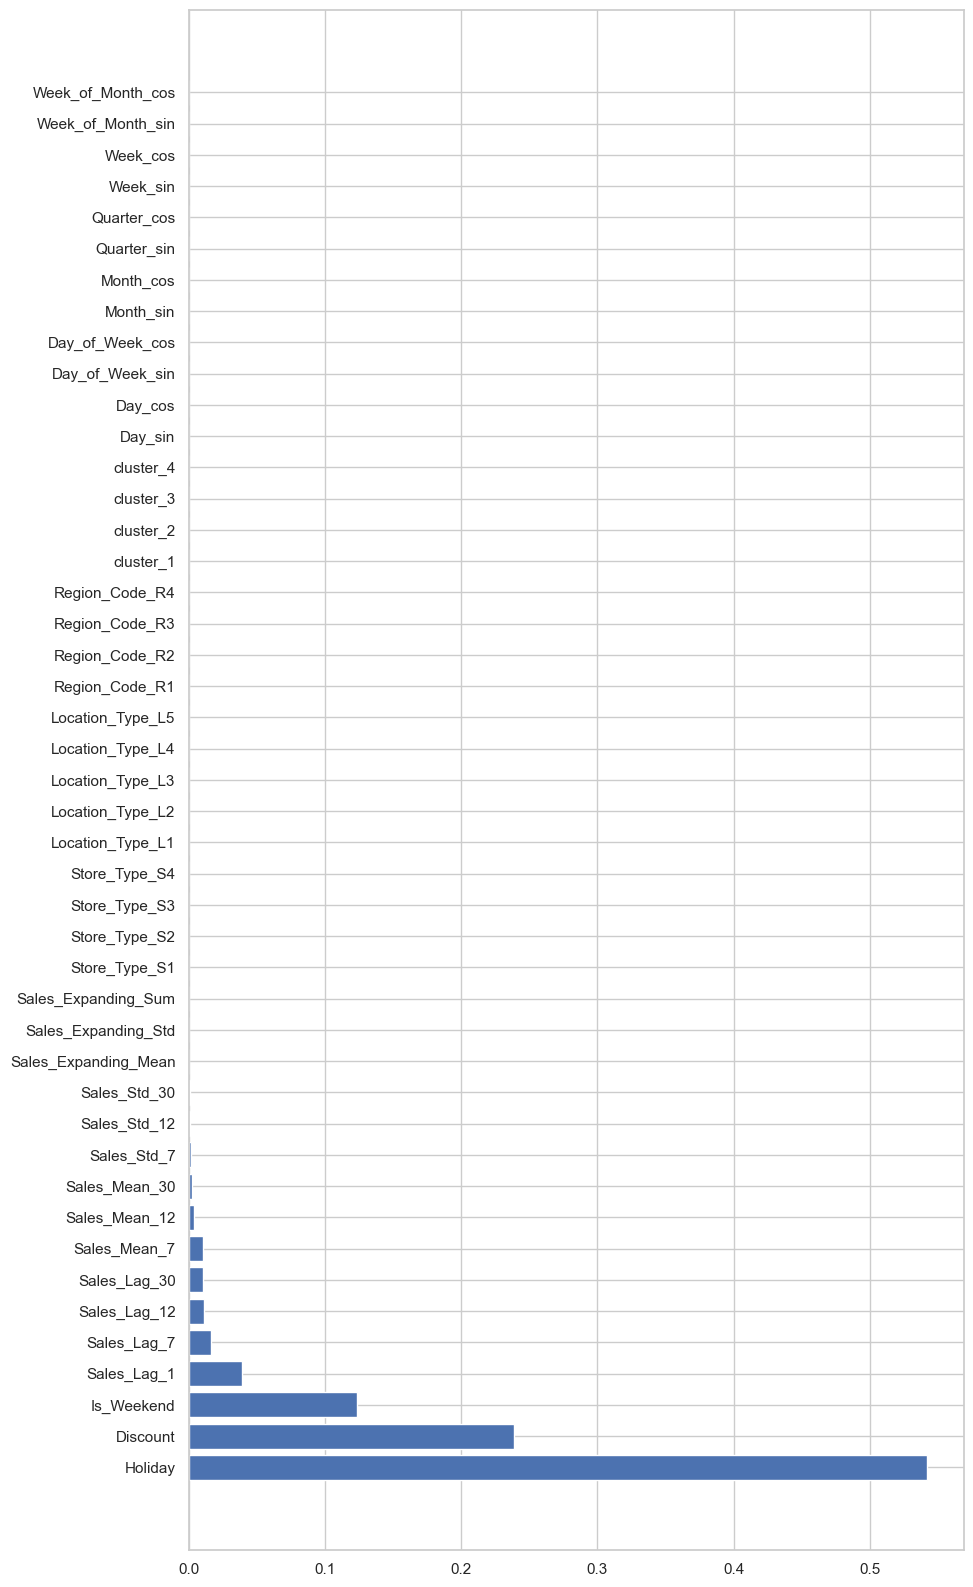

In [102]:
# plot the feature importance
plt.figure(figsize=(10, 20))
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.barh(X_train.columns, importances[indices])
plt.show()

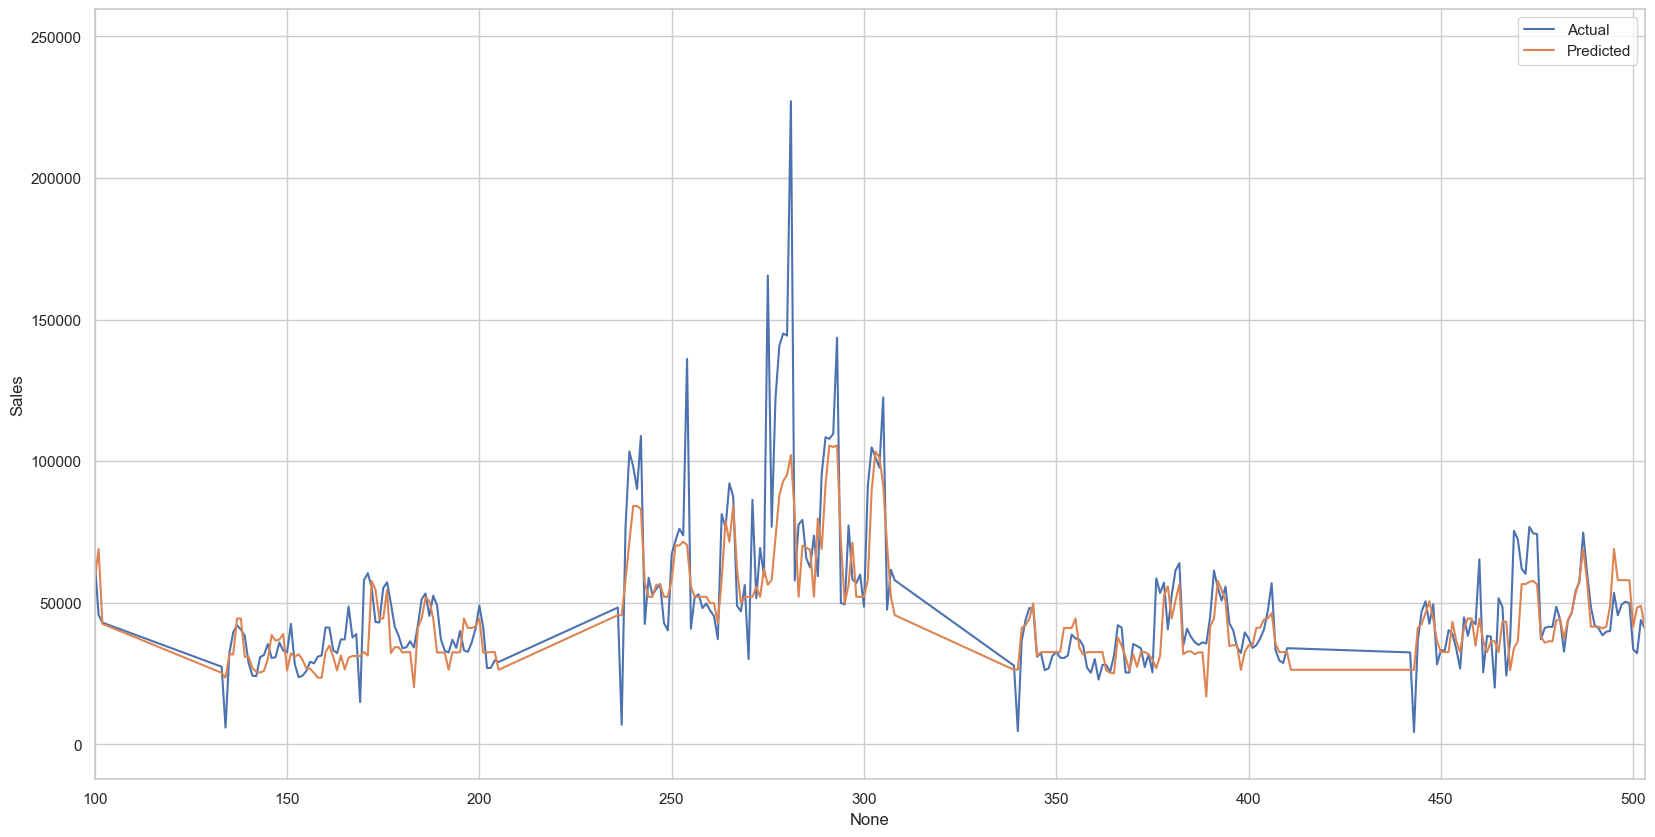

In [105]:
plt.figure(figsize=(20,10))
sns.lineplot(x=test.index, y=y_test, label="Actual")
sns.lineplot(x=test.index, y=y_pred, label="Predicted")
# show only first 100 days
plt.xlim(100,503)
plt.show()

In [106]:
mean_absolute_error(y_test, y_pred)

7965.476355682496

In [56]:
y_train_pred = rf.predict(X_train)
mean_absolute_error(y_train, y_train_pred)

1456.491097928395

In [139]:
study = optuna.create_study(direction="minimize", storage="sqlite:///optuna.db", study_name="Sales Forecasting", load_if_exists=True)

In [140]:
mlflow.set_experiment("Random Forest Optuna")
def objective_rf(trial):
    with mlflow.start_run(nested=True):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 200),
            "max_depth": trial.suggest_int("max_depth", 7, 32),
        }
        rf = RandomForestRegressor(**params, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mlflow.log_metric("mae", mae)
        mlflow.log_params(params)
        return mae
study.optimize(objective_rf, n_trials=10)

In [142]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 80,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [84]:
study.best_params

{'n_estimators': 400,
 'max_depth': 7,
 'min_samples_split': 5,
 'min_samples_leaf': 3}

# LightGBM

In [159]:
mlflow.set_experiment("LightGBM Optuna")
def objective_lgb(trial):
    with mlflow.start_run(nested=True):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 200),
            "max_depth": trial.suggest_int("max_depth", 7, 32),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
            "num_leaves": trial.suggest_int("num_leaves", 31, 127),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "boosting_type": "goss",
            "num_threads": 16,
        }
        lgbm = LGBMRegressor(**params, n_jobs=-1)
        lgbm.fit(X_train, y_train)
        y_pred = lgbm.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mlflow.log_metric("mae", mae)
        mlflow.log_params(params)
        return mae

# study = optuna.create_study(direction="minimize", storage="sqlite:///optuna.db", study_name="Sales Forecasting", load_if_exists=True)
study.optimize(objective_lgb, n_trials=20)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3565
[LightGBM] [Info] Number of data points in the train set: 139795, number of used features: 45
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 42508.380824
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_

In [160]:
mlflow.set_experiment("LightGBM")
with mlflow.start_run():
    lgbm = LGBMRegressor(**study.best_params, n_jobs=-1)
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mlflow.log_metric("mae", mae)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3565
[LightGBM] [Info] Number of data points in the train set: 139795, number of used features: 45
[LightGBM] [Info] Start training from score 42508.380824


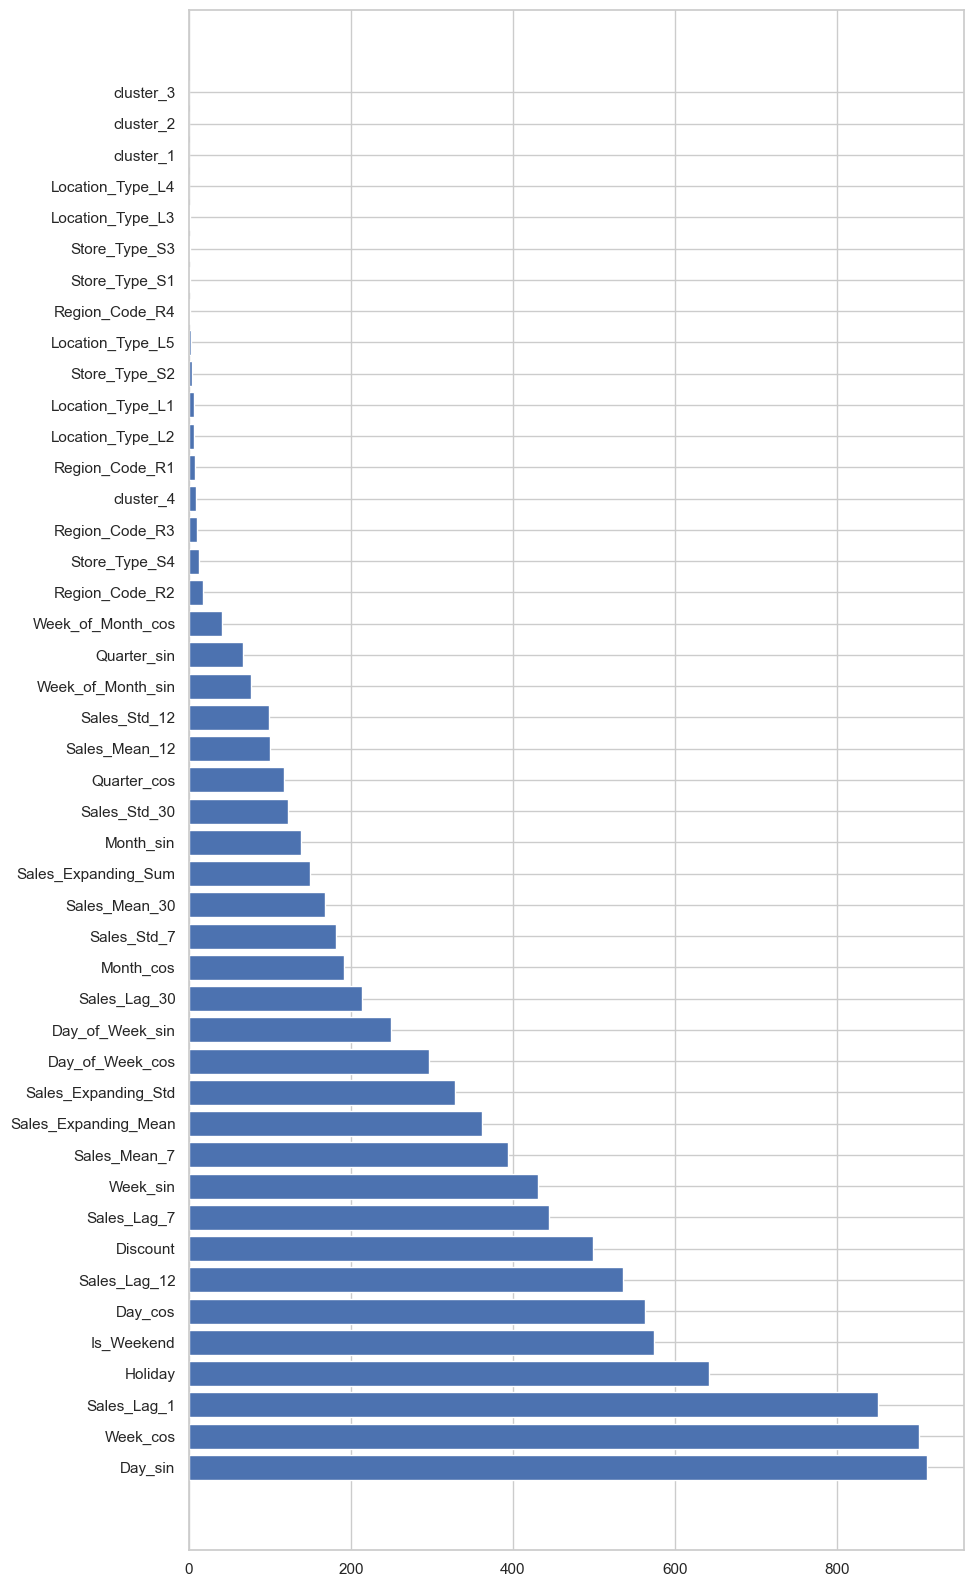

In [161]:
# plot the feature importance
plt.figure(figsize=(10, 20))
importances = lgbm.feature_importances_
indices = np.argsort(importances)[::-1]
plt.barh(X_train.columns[indices], importances[indices])
plt.show()

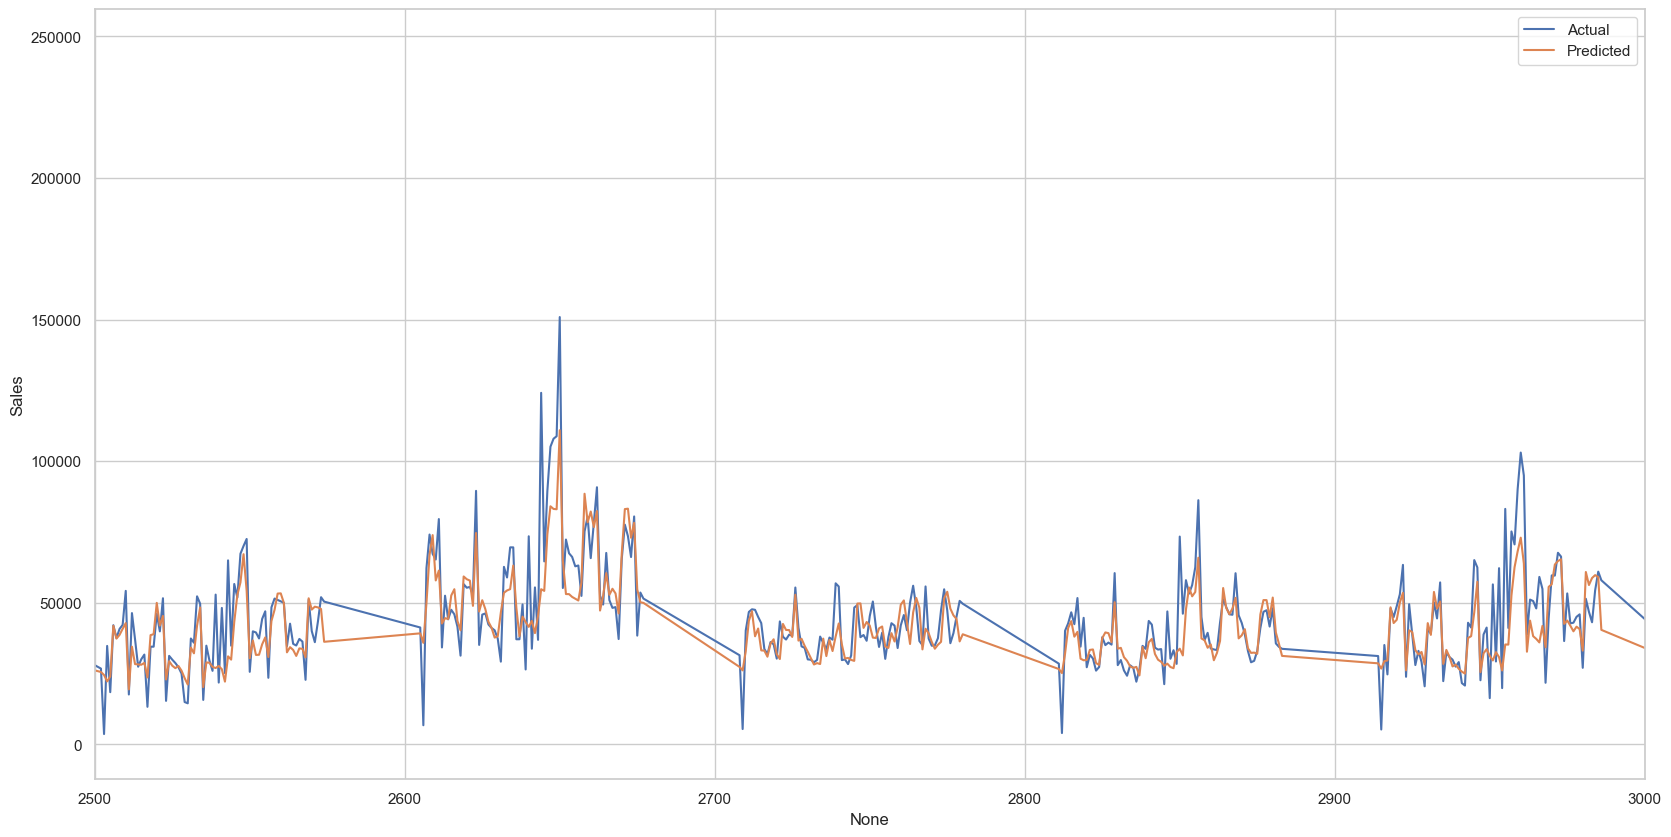

In [165]:
plt.figure(figsize=(20,10))
sns.lineplot(x=test.index, y=y_test, label="Actual")
sns.lineplot(x=test.index, y=y_pred, label="Predicted")
# show only first 100 days
plt.xlim(2500,3000)
plt.show()

# XGBoost

In [152]:
mlflow.set_experiment("XGBoost")
with mlflow.start_run():
    xgb = XGBRegressor()
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mlflow.log_metric("mae", mae)

2024/12/30 20:24:54 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost' does not exist. Creating a new experiment.


In [154]:
mlflow.set_experiment("XGBoost Optuna")
def objective_xgb(trial):
    with mlflow.start_run(nested=True):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 200),
            "max_depth": trial.suggest_int("max_depth", 7, 32),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
            "num_leaves": trial.suggest_int("num_leaves", 31, 127),
        }
        xgb = XGBRegressor(**params, n_jobs=-1)
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mlflow.log_metric("mae", mae)
        mlflow.log_params(params)
        return mae

# study = optuna.create_study(direction="minimize", storage="sqlite:///optuna.db", study_name="Sales Forecasting", load_if_exists=True)
study.optimize(objective_xgb, n_trials=10)

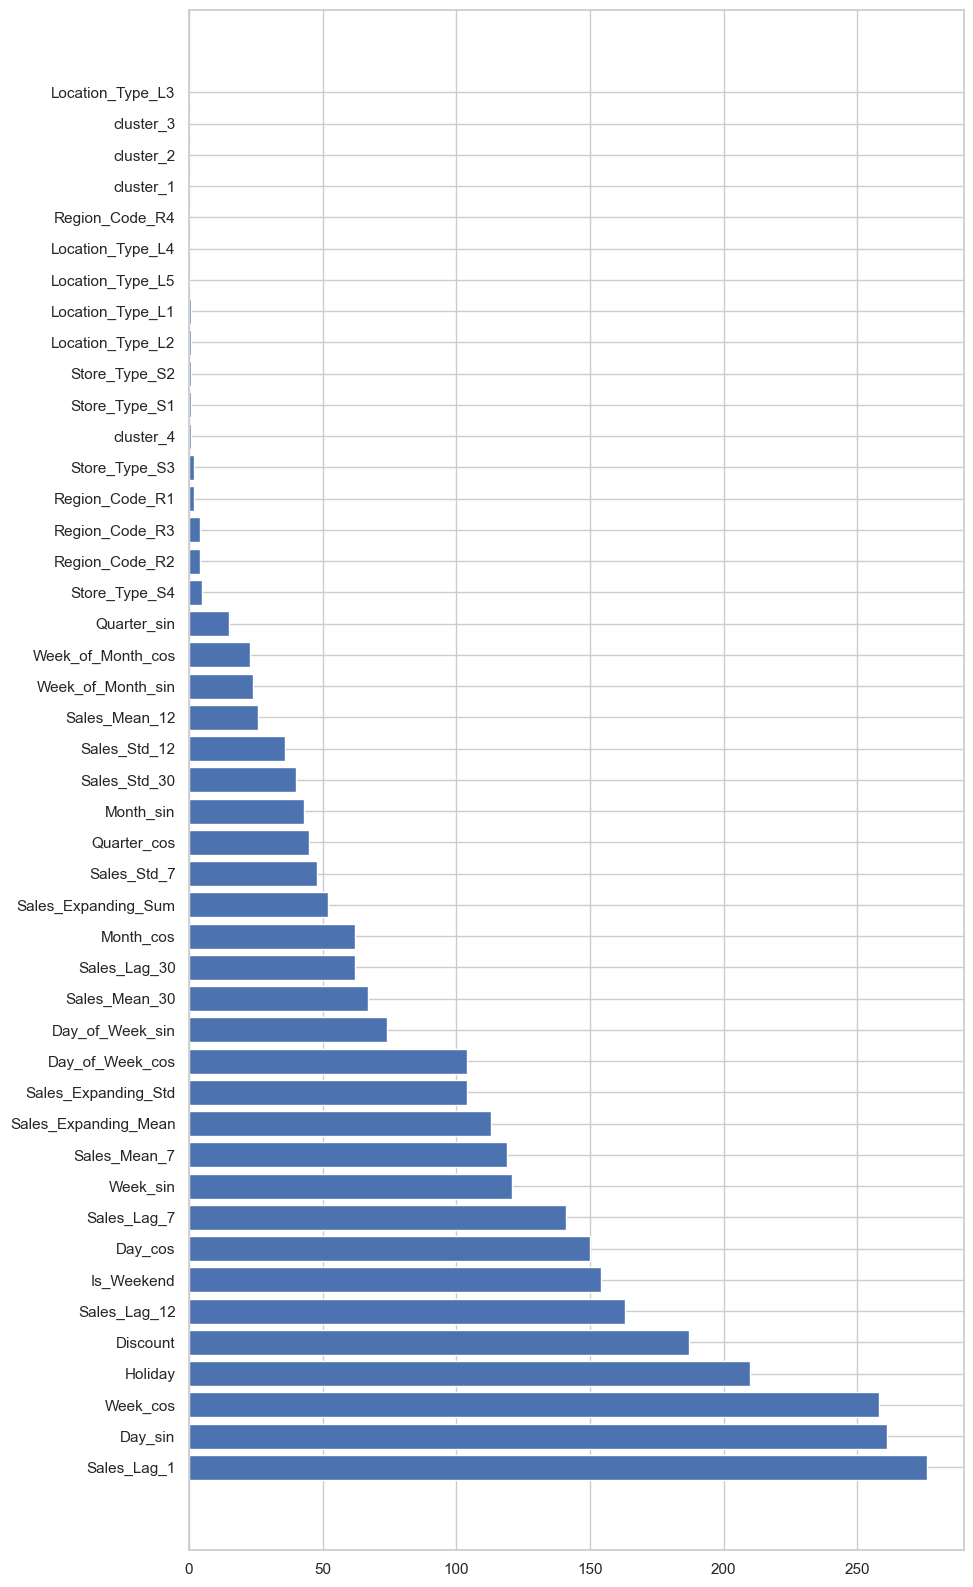